In [51]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression

### Reading in from external source

In [52]:
data = pd.read_csv("../Dataset/Keller2020/data.csv", header=[0,1,2])

In [53]:
table = data.transpose()
mirnas = data.iloc[:,0]
mirnas[:10]

0    hsa-miR-6879-5p
1    hsa-miR-1914-3p
2    hsa-miR-6873-3p
3    hsa-miR-6749-5p
4     hsa-miR-33b-3p
5    hsa-miR-6722-3p
6       hsa-miR-4497
7       hsa-miR-4496
8    hsa-miR-514b-5p
9       hsa-miR-4499
Name: (Disease, Case/Control, TimePoint), dtype: object

In [54]:
cases = []
controls = []
for ind in table.index:
    disease, case, time = ind
    if disease == "lung" and case == "1" and time.startswith("4"):
        cases.append(ind)
    elif case == "0":
        controls.append(ind)
cases = np.array(cases)
controls = np.array(controls)

In [55]:
len(cases), len(controls)

(10, 90)

In [56]:
table = pd.concat([table.loc[pd.Index(cases)], table.loc[pd.Index(controls)]])
table = table.apply(pd.to_numeric)
table.index = list(range(len(table)))
table.head()

,0,1,2,3,4,5,6,7,8,9,...,425,426,427,428,429,430,431,432,433,434
0,2.586579,1.984970,1.001199,67.783431,45.543636,13.936930,2.922348,1.919755,1.648331,4.904752,...,6.458223,3.600339,5.324236,3.692770,5.988129,1.733289,1.698204,2.036009,3.083484,19.849327
1,5.713781,2.234160,1.340979,59.474093,43.752316,14.981506,4.342706,1.698204,1.521796,3.279505,...,5.098393,3.207624,5.932174,2.756462,5.444247,1.470933,1.372984,0.993762,3.732401,17.123588
2,3.136505,2.062447,1.578979,43.752316,86.866796,16.124637,3.583264,1.041020,1.297070,3.069981,...,5.355190,3.634275,4.530009,2.057463,5.394346,1.885339,2.234160,1.145478,3.501534,15.748140
3,4.530009,3.518069,1.330037,38.233211,9.846221,6.816893,2.545676,1.542517,1.443457,5.988129,...,1.735977,1.411522,2.221556,2.992363,1.989384,2.687550,3.839025,1.793884,1.774053,8.740521
4,4.936459,2.046543,1.279034,43.752316,67.783431,16.814796,2.992363,1.287495,1.365078,3.802587,...,6.091902,3.436918,5.211109,2.595168,6.929546,1.122668,1.167561,1.030004,2.832109,31.096088


In [57]:
controls = np.array(len(cases)*[0] + len(controls)*[1])

### Drop NAN

In [58]:
mask = (table.isna().sum(axis=1) == 0).to_numpy()
controls = controls[mask]
table = table.loc[mask]

In [59]:
sick = 1 - controls

In [60]:
table = table.dropna(1)

C:\Users\OLEFRE~1\AppData\Local\Temp/ipykernel_12284/1927661217.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  table = table.dropna(1)


### T-test

In [61]:
X = table

In [62]:
X.columns

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            425, 426, 427, 428, 429, 430, 431, 432, 433, 434],
           dtype='int64', length=435)

In [63]:
X_healthy, X_cancer = X[controls == 1], X[controls == 0]

In [64]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [65]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [66]:
mirnas[lowest], pvalues

(305        hsa-miR-575
 396    hsa-miR-6821-5p
 328       hsa-miR-4459
 71        hsa-miR-6090
 320    hsa-miR-4707-3p
 Name: (Disease, Case/Control, TimePoint), dtype: object,
 array([7.23602220e-08, 1.45980133e-07, 4.30731398e-06, 4.17409870e-05,
        4.84950878e-05]))

### F-test

In [67]:
t3 = table

In [68]:
f, p = f_classif(t3, sick)

In [69]:
np.mean(p)

0.4249724112935167

### ANOVA

In [70]:
t3

,0,1,2,3,4,5,6,7,8,9,...,425,426,427,428,429,430,431,432,433,434
0,2.586579,1.984970,1.001199,67.783431,45.543636,13.936930,2.922348,1.919755,1.648331,4.904752,...,6.458223,3.600339,5.324236,3.692770,5.988129,1.733289,1.698204,2.036009,3.083484,19.849327
1,5.713781,2.234160,1.340979,59.474093,43.752316,14.981506,4.342706,1.698204,1.521796,3.279505,...,5.098393,3.207624,5.932174,2.756462,5.444247,1.470933,1.372984,0.993762,3.732401,17.123588
2,3.136505,2.062447,1.578979,43.752316,86.866796,16.124637,3.583264,1.041020,1.297070,3.069981,...,5.355190,3.634275,4.530009,2.057463,5.394346,1.885339,2.234160,1.145478,3.501534,15.748140
3,4.530009,3.518069,1.330037,38.233211,9.846221,6.816893,2.545676,1.542517,1.443457,5.988129,...,1.735977,1.411522,2.221556,2.992363,1.989384,2.687550,3.839025,1.793884,1.774053,8.740521
4,4.936459,2.046543,1.279034,43.752316,67.783431,16.814796,2.992363,1.287495,1.365078,3.802587,...,6.091902,3.436918,5.211109,2.595168,6.929546,1.122668,1.167561,1.030004,2.832109,31.096088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,7.515659,2.668237,1.873708,41.641526,78.550614,17.480883,3.387908,2.215011,1.401626,7.171026,...,3.768511,2.460019,4.127907,3.179283,2.747371,2.288662,2.887993,1.603383,2.877183,14.728697
96,10.232273,4.318441,1.753664,59.474093,32.288977,9.047622,6.144896,3.786425,1.989384,9.158041,...,2.246905,1.619397,3.653340,3.006228,2.595168,4.019735,4.680239,3.207624,1.453367,5.280803
97,11.293200,3.306345,1.591532,25.013250,86.866796,20.897139,5.932174,2.561605,1.612476,9.942280,...,3.470185,2.344041,3.977985,5.444247,3.953678,1.393112,3.996203,1.777235,2.898270,13.128558
98,7.591676,3.406488,2.435394,27.763915,82.654551,16.814796,4.710073,2.612104,1.915322,18.361865,...,3.263780,2.799438,3.533895,5.098393,2.648312,2.561605,2.767663,1.937086,2.502052,10.621846


In [71]:
X = np.array(sick).reshape(-1, 1)

In [72]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [73]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted)

0.02220645689725823

### Mean-variance-plot

In [74]:
np.mean(table)

0       6.788414
1       2.916841
2       2.239763
3      39.092832
4      80.149972
         ...    
430     2.167988
431     2.664243
432     1.778027
433     2.857663
434    16.853799
Length: 435, dtype: float64

In [75]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [76]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

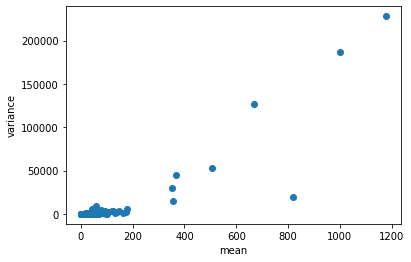

In [77]:
mean_variance_plot(table)

### Log transformation

In [78]:
log_table = np.log2(table)

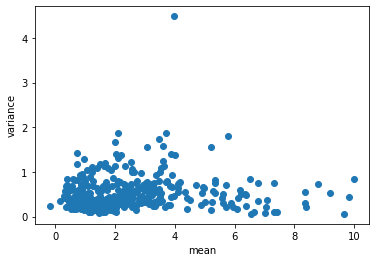

In [79]:
mean_variance_plot(log_table)

### Remove mean

In [80]:
norm_log_table = log_table - np.mean(log_table)
norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

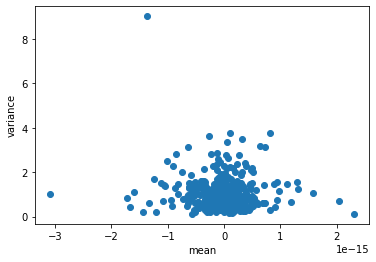

In [81]:
mean_variance_plot(norm_log_table)

### PCA

In [82]:
pca = decomposition.PCA(n_components=10)

In [83]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [84]:
pca.explained_variance_ratio_

array([0.44694081, 0.1383351 , 0.10097953, 0.05028025, 0.03447708,
       0.02723753, 0.02144941, 0.01849242, 0.01345425, 0.0109849 ])

In [85]:
components = pca.transform(norm_log_table)

In [86]:
components.shape

(98, 10)

In [87]:
sum(controls)

88

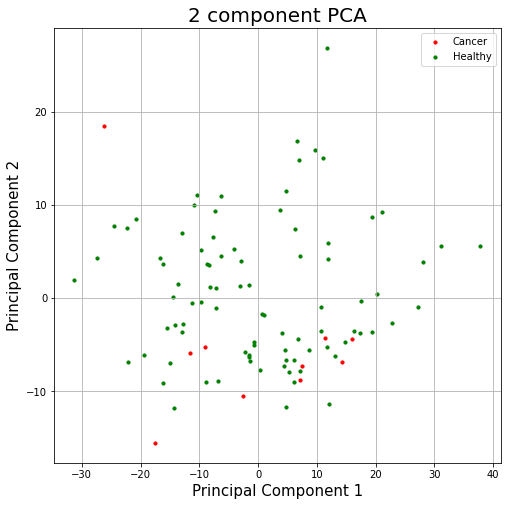

In [88]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [89]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

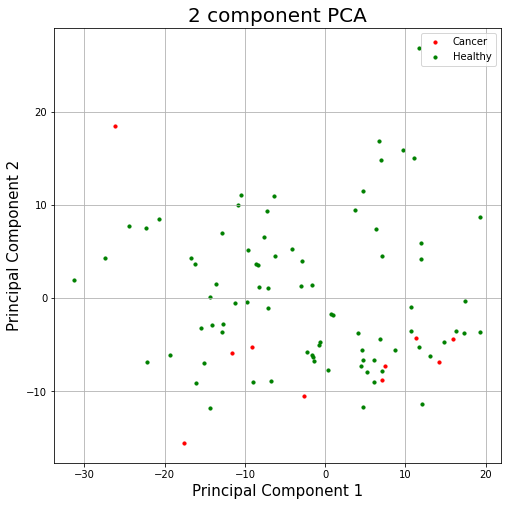

In [90]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [91]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [92]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

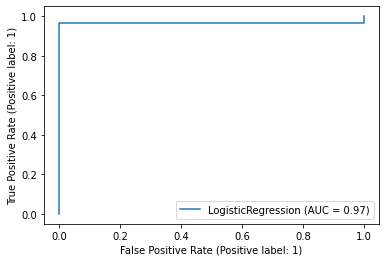

In [93]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [94]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[15:48:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

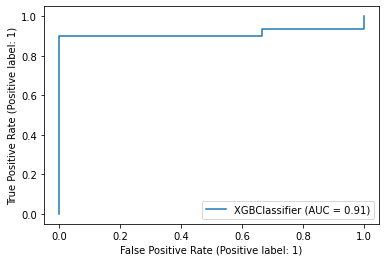

In [95]:
plot_roc_curve(model, X_test, y_test)

### Export data

In [96]:
mirnas[:10]

0    hsa-miR-6879-5p
1    hsa-miR-1914-3p
2    hsa-miR-6873-3p
3    hsa-miR-6749-5p
4     hsa-miR-33b-3p
5    hsa-miR-6722-3p
6       hsa-miR-4497
7       hsa-miR-4496
8    hsa-miR-514b-5p
9       hsa-miR-4499
Name: (Disease, Case/Control, TimePoint), dtype: object

In [97]:
from Scripts import converters

In [98]:
sequences = converters.canonical_to_seq(mirnas)

In [99]:
norm_log_table.columns = sequences
norm_log_table["cancer"] = sick
norm_log_table.head()

,CAGGGCAGGGAAGGUGGGAGAG,GGAGGGGUCCCGCACUGGGAGG,UUCUCUCUGUCUUUCUCUCUCAG,UCGGGCCUGGGGUUGGGGGAGC,CAGUGCCUCGGCAGUGCAGCCC,UGCAGGGGUCGGGUGGGCCAGG,CUCCGGGACGGCUGGGC,GAGGAAACUGAAGCUGAGAGGG,UUCUCAAGAGGGAGGCAAUCAU,AAGACUGAGAGGAGGGA,...,AAGCCCUUACCCCAAAAAGCAU,UGAUUGUCUUCCCCCACCCUCA,GGCUACAACACAGGACCCGGGC,ACACUGUCCCCUUCUCCCCAG,UGUGUGGAUCCUGGAGGAGGCA,UGUGGGUUCUGGGUUGGGGUGA,AAAGACCCAUUGAGGAGAAGGU,CAGCCUCUGCCCUUGGCCUCC,UCGCCUCCUCCUCUCCC,cancer
0,-1.752429,-0.662890,-1.500480,1.556918,-0.926410,-0.119258,-0.468877,0.228015,0.141744,-1.046940,...,0.584215,0.618859,0.263377,0.839192,-0.246544,-0.750701,0.510153,0.261578,0.660547,1
1,-0.130986,-0.420943,-0.902675,1.289365,-1.008503,0.028605,0.341512,-0.022862,-0.021665,-1.870426,...,0.347923,0.840062,-0.334894,0.644385,-0.582321,-1.185622,-0.957245,0.652322,0.358345,1
2,-1.358040,-0.584555,-0.568424,0.661291,0.394617,0.179042,-0.051751,-1.024050,-0.348560,-2.005497,...,0.603409,0.288359,-0.933258,0.625546,-0.074514,-0.189532,-0.666569,0.521692,0.187035,1
3,-0.605949,0.507977,-0.919436,0.385427,-4.059828,-1.582337,-0.751189,-0.219585,-0.129789,-0.638637,...,-1.331452,-1.169355,-0.166897,-1.415261,0.650793,0.918005,0.251128,-0.869364,-1.017475,1
4,-0.430159,-0.600392,-0.999433,0.661291,-0.112877,0.264786,-0.420439,-0.589308,-0.244009,-1.567660,...,0.489179,0.574921,-0.458253,1.137920,-1.135092,-1.517195,-0.883961,0.087601,1.578961,1


In [100]:
norm_log_table.to_csv("../TransformedData/Keller2020.csv", index=False)